In [1]:
import os
import numpy as np
from PIL import Image, ImageDraw
from scipy.ndimage import binary_fill_holes
import cv2
import matplotlib.pyplot as plt

(2048, 2448)


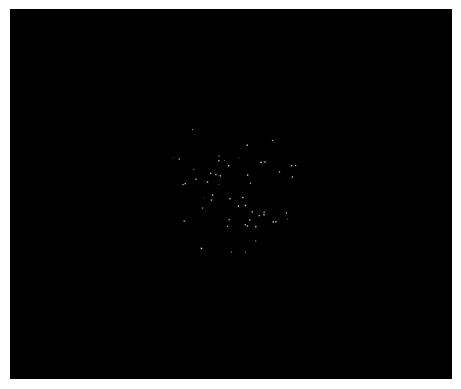

In [15]:
test_image = '/work/users/a/a/aarav7/SNU16/SNU16_JQ_Masks/SNU16_JC_JQ1_IC50_24h_100_Merge.tif'
tiff_image = Image.open(test_image)

# Convert to a NumPy array
image_array = np.array(tiff_image)
print(image_array.shape)

# Display the image using matplotlib
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Hide the axes for better visualization
plt.show()

In [ ]:
# Paths to the directories
true_segmentation_folder = '/work/users/a/a/aarav7/Masked_img_3_and_4_1164imgs/Segmentation_labels'
predicted_segmentation_folder = '/work/users/a/a/aarav7/Split1/filled_predicted_masks'
output_folder = '/work/users/a/a/aarav7/Split1/overlay_masks'

# Define the colors for the output image
color_green = [0, 255, 0]     # Green for true positive (both true and predicted positive)
color_red = [255, 0, 0]       # Red for false negative (true positive, predicted negative)
color_orange = [255, 165, 0]  # Orange for false positive (true negative, predicted positive)
color_black = [0, 0, 0]       # Black for true negative

# Fixed image size (2048x2448)
fixed_image_shape = (2048, 2448)

def png_to_binary_mask(png_image):
    red_mask = (png_image[:, :, 0] == 240) & (png_image[:, :, 1] == 2) & (png_image[:, :, 2] == 127)
    return red_mask.astype(np.uint8)

# Function to convert the predicted TIFF image to a binary mask
def tiff_to_binary_mask(tiff_image):
    # Convert the image to a NumPy array
    tiff_array = np.array(tiff_image)

    # Assuming the red part of the image is positive, create a binary mask for red pixels
    binary_mask = (tiff_array != 0).astype(np.uint8)
    return binary_mask

def fill_with_contours(coords, image_shape):
    """Given edge coordinates, fill the segmentation region using contours."""
    # Create a binary mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Draw the edges on the mask
    for coord in coords:
        mask[coord[1], coord[0]] = 1

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Fill the contours
    cv2.drawContours(mask, contours, -1, color=1, thickness=cv2.FILLED)

    return mask

# Iterate over each file in the true segmentation folder
for filename in os.listdir(true_segmentation_folder):
    if filename.endswith('.npz'):  # Only consider .npz files
        true_seg_path = os.path.join(true_segmentation_folder, filename)
        predicted_seg_path = os.path.join(predicted_segmentation_folder, f"{os.path.splitext(filename)[0]}.tif")

        # Check if the corresponding predicted segmentation TIFF file exists
        if os.path.exists(predicted_seg_path):
            # Load the true segmentation .npz file
            true_seg = np.load(true_seg_path)

            # Load the predicted segmentation .tiff file
            image = Image.open(predicted_seg_path) 
            predicted_image = np.array(image) 

            # Convert the TIFF image to a binary mask (1 for positive, 0 for negative)
            predicted_mask = tiff_to_binary_mask(predicted_image)

            # Create an empty RGB image with the fixed size (2048x2448)
            output_image = np.full((*fixed_image_shape, 3), color_black, dtype=np.uint8)

            true_mask = np.zeros(fixed_image_shape, dtype=np.uint8)
            
            for key in true_seg.files:
                if key.startswith('arr_') and (int(key.split('_')[1]) % 3 == 2):
                    coords = true_seg[key].reshape(-1, 2)
                    filled_mask = fill_with_contours(coords, fixed_image_shape)
                    true_mask = np.maximum(true_mask, filled_mask)
            output_image[true_mask == 1] = color_red  # Initially mark all true positives as red

            # Ensure that the predicted mask is the same size as the fixed image
            predicted_mask_resized = cv2.resize(predicted_mask, (fixed_image_shape[1], fixed_image_shape[0]), interpolation=cv2.INTER_NEAREST)

            # Overlay the masks onto the output image
            for y in range(fixed_image_shape[0]):
                for x in range(fixed_image_shape[1]):
                    if true_mask[y, x] == 1 and predicted_mask_resized[y, x] == 1:
                        output_image[y, x] = color_green  # Both true and predicted are positive
                    elif true_mask[y, x] == 1 and predicted_mask_resized[y, x] == 0:
                        output_image[y, x] = color_red  # True positive, predicted negative
                    elif true_mask[y, x] == 0 and predicted_mask_resized[y, x] == 1:
                        output_image[y, x] = color_orange  # True negative, predicted positive
                    # Else, the pixel remains black

            # Display the output image instead of saving it
            output_image_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")
            Image.fromarray(output_image).save(output_image_path)

        else:
            print(f"Predicted TIFF file for {filename} not found in {predicted_segmentation_folder}")


Predicted TIFF file for COLO320DM_qPCR_JQ1_24h_DMSO_104_Merge.npz not found in /work/users/a/a/aarav7/Split1/filled_predicted_masks
Predicted TIFF file for COLO320DM_qPCR_JQ1_24h_DMSO_111_Merge.npz not found in /work/users/a/a/aarav7/Split1/filled_predicted_masks
